# Prediction of the Box-Counting Dimension of Metal Nanoparticles: Data Processing (Data-Driven Reduction)

This notebook contains the results from data processing in preparation for the machine learning predictions of the box-counting dimensions, $D_B$, computed for metal (specifically the mono-, bi-, and tri-metallic combinations of gold, palladium, and platinum) nanoparticles. The exercise is an attempt to explore the possibility of using a machine learning model to compute the $D_B$ values to save computational costs. The $D_B$ values are computed using [Sphractal](https://github.com/jon-ting/sphractal), a Python package for the estimation of the fractal dimension of the surfaces of atomistic objects via box-counting approaches.

## Outline

[Notebook Setups](#setup)

[Data Sets](#datasets)

[Monometallic Nanoparticles](#mnps)

<a id='setup'></a>
## Notebook Setups

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import relevant libraries
from os import chdir, listdir
import pickle
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# from sklearnex import patch_sklearn
# patch_sklearn()
import sklearn

from natsort import natsorted
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# chdir('/scratch/q27/jt5911')
from trainEvalModels import rmNullLowVarFeats, rmHighCorrFeats
from corrAnalysis import plotFeatsBCDcorrBar

# Print package versions for reproducibility
print('Versions of imported libraries:')
print(f"  matplotlib: {mpl.__version__}")
print(f"  numpy: {np.__version__}")
print(f"  pandas: {pd.__version__}")
print(f"  seaborn: {sns.__version__}")
print(f"  scikit-learn: {sklearn.__version__}")

Versions of imported libraries:
  matplotlib: 3.9.2
  numpy: 1.24.4
  pandas: 1.5.3
  seaborn: 0.12.2
Versions of imported libraries:
  matplotlib: 3.9.2
  numpy: 1.24.4
  pandas: 1.5.3
  seaborn: 0.12.2
  scikit-learn: 1.4.0


Below are some general settings for plotting figures:

In [3]:
# Settings for figures
sns.set_theme(context='paper', style='ticks', palette='colorblind', font='sans-serif', font_scale=1, color_codes=True, rc=None)  # Options are: {paper, notebook, talk, poster}
figSize, DPI, fontSize, labelSize = (3.5, 2.5), None, 'medium', 'small'
legendSize, lineWidth, markerSize = 'x-small', 1, 3
# SMALL_SIZE, MEDIUM_SIZE, LARGE_SIZE, TITLE_SIZE = 8, 10, 12, 14
# plt.rc('font', size=LARGE_SIZE)  # controls default text sizes
# plt.rc('axes', titlesize=TITLE_SIZE)  # fontsize of the axes title
# plt.rc('axes', labelsize=LARGE_SIZE)  # fontsize of the x and y labels
# plt.rc('xtick', labelsize=LARGE_SIZE)  # fontsize of the tick labels
# plt.rc('ytick', labelsize=LARGE_SIZE)  # fontsize of the tick labels
# plt.rc('legend', fontsize=LARGE_SIZE)  # legend fontsize
# plt.rc('figure', titlesize=TITLE_SIZE)  # fontsize of the figure title
# PLOT_COLOURS = ['#212121', '#3F51B5', '#303F9F', '#FF5252', '#D32F2F']  # black, blue, deep blue, red, deep red from https://www.materialpalette.com
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#303F9F', '#FF5252', '#D32F2F'])

Some handy global variables:

In [4]:
VAR_THRESH = 0.0  # Value other than 0.0 is difficult to decide non-arbitrarily
VERBOSE = True
TRANS_PERC = False
DATA_DIR = '/mnt/c/Users/ASUS/Documents/PhD/Workstation/PaperDrafts/causPath/data'
FIG_DIR = '/mnt/c/Users/ASUS/Documents/PhD/Workstation/PaperDrafts/causPath/figs'

Some handy general functions:

In [5]:
def readPickle(picklePath):
    with open(picklePath, 'rb') as f: 
        df = pickle.load(f)
    df['rangeLenVX'] = df.apply(lambda f: f['maxLenVX'] - f['minLenVX'], axis=1)
    df['rangeLenEX'] = df.apply(lambda f: f['maxLenEX'] - f['minLenEX'], axis=1)
    return df

In [6]:
def loadCSV(csvFilePath, isMono=True, molLabels=True, ele='Au', transPerc=True):
    """
    The monometallic dataset has different naming for certain features, hence why 'isMono' needs to be specified.
    """
    featDF = pd.read_csv(csvFilePath, sep=',', header=0)

    if isMono:
        featDF = featDF.rename(columns={'N_total': 'N_atom_total', 'N_bulk': 'N_atom_bulk', 'N_surface': 'N_atom_surface', 
                                        'Avg_total': 'MM_TCN_avg', 'Avg_bulk': 'MM_BCN_avg', 'Avg_surf': 'MM_SCN_avg', 
                                        'Avg_bonds': 'BL_avg', 'Std_bonds': 'BL_std', 'Max_bonds': 'BL_max', 'Min_bonds': 'BL_min', 'N_bonds': 'BL_num',
                                        'angle_avg': 'BA1_avg', 'angle_std': 'BA1_std'}, 
                               inplace=False)
        eleSpecificFeats = [feat for feat in featDF.columns if 'CN_' in feat 
                                                            or 'BL_' in feat
                                                            or 'BA1_' in feat]
        # Rename and generate element-specific features to match bimetallic and trimetallic feature names
        eleSpecNewFeatNamesDict = {}
        for feat in eleSpecificFeats:
            eleSpecNewFeatName = f"MMM_{feat}" if 'BA1_' in feat else f"MM_{feat}"
            eleSpecNewFeatNamesDict[feat] = eleSpecNewFeatName
            eleSpecNewFeatName = f"{ele}{ele}{ele}_{feat}" if 'BA1_' in feat else f"{ele}{ele}_{feat}"
            featDF[eleSpecNewFeatName] = featDF[feat]
        featDF = featDF.rename(columns=eleSpecNewFeatNamesDict, inplace=False)
            
        # Rename q6q6 features to match bimetallic and trimetallic q6q6 feature names
        q6q6Feats = [feat for feat in featDF.columns if 'q6q6_T_' in feat or 'q6q6_B_' in feat or 'q6q6_S_' in feat]
        q6q6NewFeatNamesDict = {}
        for feat in q6q6Feats:
            q6q6NewFeatName = f"{feat[:6]}_{feat[6:]}"
            q6q6NewFeatNamesDict[feat] = q6q6NewFeatName
        featDF = featDF.rename(columns=q6q6NewFeatNamesDict, inplace=False)
    
    # Replace count features with percentages
    if transPerc:
        bulkAtomFeats = [feat for feat in featDF.columns if ('BCN' in feat and '_avg' not in feat)
                                                         or ('BGCN' in feat and '_avg' not in feat)
                                                         or 'q6q6_B_' in feat]
        surfAtomFeats = [feat for feat in featDF.columns if ('SCN' in feat and '_avg' not in feat)
                                                         or ('SGCN' in feat and '_avg' not in feat)
                                                         or ('SOCN' in feat and '_avg' not in feat)
                                                         or ('SOGCN' in feat and '_avg' not in feat)
                                                         or 'q6q6_S_' in feat 
                                                         or 'Curve' in feat
                                                         or 'S_100' in feat
                                                         or 'S_111' in feat
                                                         or 'S_110' in feat
                                                         or 'S_311' in feat]
        totAtomFeats = [feat for feat in featDF.columns if ('MM_TCN' in feat and '_avg' not in feat)
                                                        or ('TGCN' in feat and '_avg' not in feat)
                                                        or 'q6q6_T_' in feat
                                                        or 'FCC' in feat 
                                                        or 'HCP' in feat
                                                        or 'ICOS' in feat
                                                        or 'DECA' in feat]
        numBulkAtomFeat = featDF['N_atom_bulk']
        numSurfAtomFeat = featDF['N_atom_surface']
        numTotalAtomFeat = featDF['N_atom_total']
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            for col in bulkAtomFeats:
                featDF[f"{col}"] = featDF[col] / numBulkAtomFeat * 100
            for col in surfAtomFeats:
                featDF[f"{col}"] = featDF[col] / numSurfAtomFeat * 100
            for col in totAtomFeats:
                featDF[f"{col}"] = featDF[col] / numTotalAtomFeat * 100
        featDF.drop(bulkAtomFeats, axis=1, inplace=True)
        featDF.drop(surfAtomFeats, axis=1, inplace=True)
        featDF.drop(totAtomFeats, axis=1, inplace=True)

    labelFeats = [feat for feat in featDF.columns if 'Surf_defects' in feat or 'Surf_micros' in feat or 'Surf_facets' in feat or '_E' in feat]
    labelDF = featDF[labelFeats]
    featDF.drop(['ID'] + labelFeats, axis=1, inplace=True)
    return featDF, labelDF

In [7]:
def loadFeats(pklFilePath):
    """
    Load feature dataframe saved in pickle file.
    """
    with open(pklFilePath, 'rb') as f:
        featsDF = pickle.load(f)
    return featsDF

<a id='datasets'></a>
## Datasets

The datasets used here are atomic coordinates of simulated metal nanoparticles generated for studies on the impact of polydispersivity on the properties of metal nanoparticle electrocatalyst ensembles. All data sets are hosted at [CSIRO Data Access Portal](https://data.csiro.au/collection/). The links are provided below:
- [gold](https://data.csiro.au/collection/csiro:40669)
- [palladium](https://data.csiro.au/collection/csiro:40618)
- [platinum](https://data.csiro.au/collection/csiro:36491)

<a id='mnps'></a>
## Monometallic Nanoparticles

Here we process the data for a machine learning model that aims to predict the $D_B$ values of a set of simulated monometallic nanoparticles (either gold, palladium, or platinum) to be trained on. We aim to ultimately study the feature importance profile to understand the influential features in the prediction of the $D_B$ values, and investigate the conditions that give rise to rougher nanoparticles.

### Data Loading

In [21]:
# Load features
MNPDF = loadFeats(f"{DATA_DIR}/MNPDF.pkl")
MNPFeatsDF, MNPtotEs, MNPformEs = MNPDF.iloc[:, :-2], MNPDF.iloc[:, -2], MNPDF.iloc[:, -1]
# MNPFeatsDF = loadFeats(f"{DATA_DIR}/reducedMNP_nanoparticle_data.pkl")
# MNPFeatsDF = MNPFeatsDF.drop(['D_avg', 'Ele'], axis=1, inplace=False)

# # Load labels and extract useful label column(s)
feats = ['DBoxEX']  # 'R2EX', 'minLenEX', 'maxLenEX', 'rangeLenEX', 'lowCIEX', 'upCIEX'
AuLabelsDF = readPickle(f"{DATA_DIR}/allAuNPsEX.pickle")
AuLabelDF = AuLabelsDF[feats]
AuLabelDF = AuLabelDF.reset_index(inplace=False)
AuLabelDF = AuLabelDF.drop(['index'], axis=1, inplace=False)
PdLabelsDF = readPickle(f"{DATA_DIR}/allPdNPsEX.pickle")
PdLabelDF = PdLabelsDF[feats]
PdLabelDF = PdLabelDF.reset_index(inplace=False)
PdLabelDF = PdLabelDF.drop(['index'], axis=1, inplace=False)
PtLabelsDF = readPickle(f"{DATA_DIR}/allPtNPsEX.pickle")
PtLabelDF = PtLabelsDF[feats]
PtLabelDF = PtLabelDF.reset_index(inplace=False)
PtLabelDF = PtLabelDF.drop(['index'], axis=1, inplace=False)
MNPLabelDF = pd.concat([AuLabelDF, PdLabelDF, PtLabelDF], axis=0)
MNPLabelDF = MNPLabelDF.reset_index(inplace=False)
MNPLabelDF = MNPLabelDF.drop(['index'], axis=1, inplace=False)
MNPLabelDF = MNPLabelDF.iloc[MNPFeatsDF.index]

# Not using the original labels in this notebook, delete variables to free up memory
del AuLabelsDF, PdLabelsDF, PtLabelsDF

# for feat in MNPFeatsDF.columns:
#     print(feat)

In [16]:
### Data Processing

# Rearrange feature columns based on priorities to be kept (for the highly correlated feature removal step)
sortedFeats = ['T', 'time', 'tau',
               'MM_SCN_avg', 'q6q6_avg_surf', 
               'S_100', 'S_111', 'S_110', 'S_311', 
               'N_atom_surface', 'N_atom_bulk', 'Volume', 'N_atom_total', 
               'R_avg', 'R_diff', 'R_std', 'R_min', 'R_max', 'R_skew', 'R_kurt', 
               
               'MM_TCN_avg', 'MM_BCN_avg', 
               'MM_BL_avg', 'MM_BL_std', 'MM_BL_num', 'MM_BL_max', 'MM_BL_min', 
               'MMM_BA1_avg', 'MMM_BA1_std', 
               'q6q6_avg_total', 'q6q6_avg_bulk', 
                              
               'FCC', 'HCP', 'ICOS', 'DECA', 
               
               'Curve_1-10', 'Curve_11-20', 'Curve_21-30', 'Curve_31-40', 'Curve_41-50', 'Curve_51-60', 'Curve_61-70', 'Curve_71-80', 'Curve_81-90', 
               'Curve_91-100', 'Curve_101-110', 'Curve_111-120', 'Curve_121-130', 'Curve_131-140', 'Curve_141-150', 'Curve_151-160', 'Curve_161-170', 'Curve_171-180', 
               
               'MM_SCN_0', 'MM_SCN_1', 'MM_SCN_2', 'MM_SCN_3', 'MM_SCN_4', 'MM_SCN_5', 'MM_SCN_6', 'MM_SCN_7', 'MM_SCN_8', 'MM_SCN_9', 'MM_SCN_10', 
               'MM_SCN_11', 'MM_SCN_12', 'MM_SCN_13', 'MM_SCN_14', 'MM_SCN_15', 'MM_SCN_16', 'MM_SCN_17', 'MM_SCN_18', 'MM_SCN_19', 'MM_SCN_20', 
               'q6q6_S_0', 'q6q6_S_1', 'q6q6_S_2', 'q6q6_S_3', 'q6q6_S_4', 'q6q6_S_5', 'q6q6_S_6', 'q6q6_S_7', 'q6q6_S_8', 'q6q6_S_9', 'q6q6_S_10', 
               'q6q6_S_11', 'q6q6_S_12', 'q6q6_S_13', 'q6q6_S_14', 'q6q6_S_15', 'q6q6_S_16', 'q6q6_S_17', 'q6q6_S_18', 'q6q6_S_19', 'q6q6_S_20', 'q6q6_S_20+', 
               
               'MM_TCN_0', 'MM_TCN_1', 'MM_TCN_2', 'MM_TCN_3', 'MM_TCN_4', 'MM_TCN_5', 'MM_TCN_6', 'MM_TCN_7', 'MM_TCN_8', 'MM_TCN_9', 'MM_TCN_10', 
               'MM_TCN_11', 'MM_TCN_12', 'MM_TCN_13', 'MM_TCN_14', 'MM_TCN_15', 'MM_TCN_16', 'MM_TCN_17', 'MM_TCN_18', 'MM_TCN_19', 'MM_TCN_20', 
               'q6q6_T_0', 'q6q6_T_1', 'q6q6_T_2', 'q6q6_T_3', 'q6q6_T_4', 'q6q6_T_5', 'q6q6_T_6', 'q6q6_T_7', 'q6q6_T_8', 'q6q6_T_9', 'q6q6_T_10', 
               'q6q6_T_11', 'q6q6_T_12', 'q6q6_T_13', 'q6q6_T_14', 'q6q6_T_15', 'q6q6_T_16', 'q6q6_T_17', 'q6q6_T_18', 'q6q6_T_19', 'q6q6_T_20', 'q6q6_T_20+', 

               'MM_BCN_0', 'MM_BCN_1', 'MM_BCN_2', 'MM_BCN_3', 'MM_BCN_4', 'MM_BCN_5', 'MM_BCN_6', 'MM_BCN_7', 'MM_BCN_8', 'MM_BCN_9', 'MM_BCN_10', 
               'MM_BCN_11', 'MM_BCN_12', 'MM_BCN_13', 'MM_BCN_14', 'MM_BCN_15', 'MM_BCN_16', 'MM_BCN_17', 'MM_BCN_18', 'MM_BCN_19', 'MM_BCN_20', 
               'q6q6_B_0', 'q6q6_B_1', 'q6q6_B_2', 'q6q6_B_3', 'q6q6_B_4', 'q6q6_B_5', 'q6q6_B_6', 'q6q6_B_7', 'q6q6_B_8', 'q6q6_B_9', 'q6q6_B_10', 
               'q6q6_B_11', 'q6q6_B_12', 'q6q6_B_13', 'q6q6_B_14', 'q6q6_B_15', 'q6q6_B_16', 'q6q6_B_17', 'q6q6_B_18', 'q6q6_B_19', 'q6q6_B_20', 'q6q6_B_20+']
MNPFeatsDF = MNPFeatsDF[[feat for feat in sortedFeats if feat in MNPFeatsDF.columns]]

##### Feature Selection

In [23]:
# Remove features with zero variance and the second feature of each highly correlated feature pairs
CORR_THRESH = 0.8
MNPFeatsNoLowVarDF = rmNullLowVarFeats(featsDF=MNPFeatsDF, rmNull=False, varThresh=VAR_THRESH, verbose=VERBOSE)
MNPFeatsNoLowVarHighCorrDF = rmHighCorrFeats(featsDF=MNPFeatsNoLowVarDF, corrThresh=CORR_THRESH, verbose=VERBOSE)

del MNPFeatsNoLowVarDF

Removing the features with variance below 0.00...
  Original number of features: 134
  Total number of features left: 134

Removing the second feature from every pair of features with correlation above 0.80...
  Original number of features: 134
    N_atom_total N_atom_bulk:    0.999
    N_atom_total N_atom_surface:    0.976
    N_atom_total R_min:    0.873
    N_atom_total R_max:    0.869
    N_atom_total R_avg:    0.951
    N_atom_total Curve_21-30:    0.870
    N_atom_total MM_TCN_7:    0.821
    N_atom_total MM_TCN_12:    0.971
    N_atom_total MM_BCN_12:    0.971
    N_atom_total MM_SCN_7:    0.821
    N_atom_total MM_SCN_10:    0.835
    N_atom_total MM_BL_num:    1.000
    N_atom_total FCC:    0.853
    N_atom_total q6q6_T_10:    0.803
    N_atom_total q6q6_T_12:    0.907
    N_atom_total q6q6_B_12:    0.907
    Volume MM_TCN_avg:    0.861
    R_diff R_std:    0.922
    S_100 q6q6_S_8:    0.810
    S_111 Curve_1-10:    0.887
    S_111 MM_TCN_9:    0.889
    S_111 MM_SCN_9:    0.8

##### Data Analysis

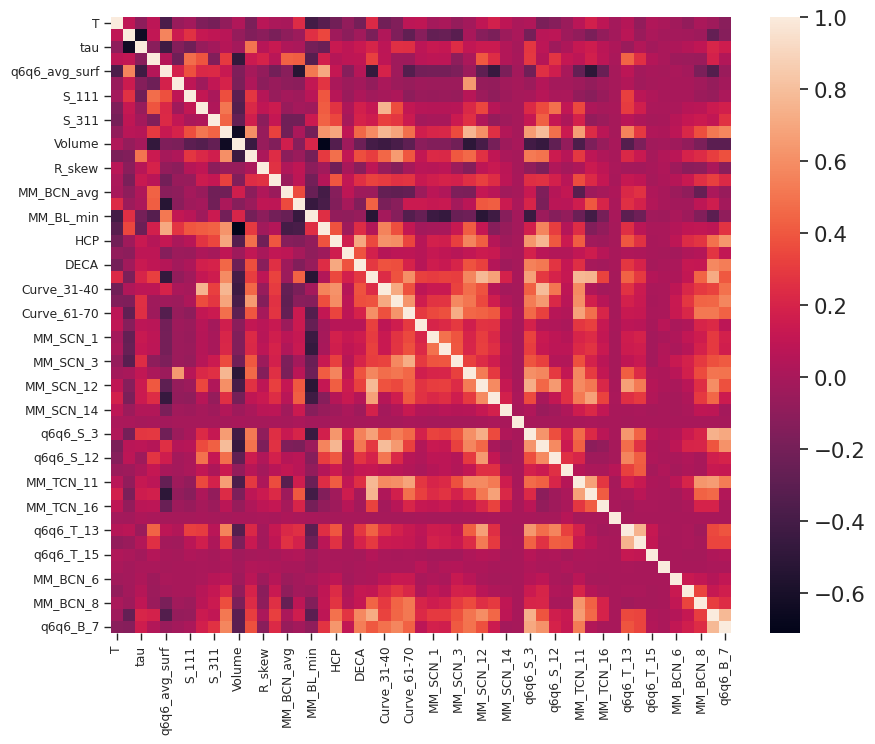

In [18]:
# Correlation heatmap
fig, ax = plt.subplots(figsize=(10, 8), dpi=DPI)
sns.set(font_scale=1.4)
g = sns.heatmap(MNPFeatsNoLowVarHighCorrDF.corr(), ax=ax)
plt.savefig(f"{FIG_DIR}/MNPENoC{int(CORR_THRESH * 100)}CorrHeatmap.png", bbox_inches='tight')

In [24]:
# Merge labels with features
# MNPDF = pd.concat([MNPFeatsNoLowVarHighCorrDF, MNPLabelDF], axis=1)
MNPDF = pd.concat([MNPFeatsNoLowVarHighCorrDF, MNPtotEs, MNPformEs], axis=1)
display(MNPDF)
display(MNPDF.describe())
del MNPFeatsNoLowVarHighCorrDF

,T,tau,time,N_atom_total,Volume,R_diff,R_skew,R_kurt,S_100,S_111,...,q6q6_avg_total,q6q6_T_4,q6q6_T_6,q6q6_T_13,q6q6_T_14,q6q6_T_15,q6q6_S_12,q6q6_S_13,Total_E,Formation_E
0,273,0.000025,1,1599,0.000037,0.38618,-0.00435,-0.00731,0,81,...,2.5153,74,47,8,2,0,0,1,-5908.6345,343.4555
1,273,0.000025,2,1642,0.000036,0.87760,0.20673,0.99355,0,65,...,2.5335,94,71,10,2,0,1,0,-6035.4034,384.8166
2,273,0.000025,3,4637,0.000013,0.91106,0.03618,0.12311,4,204,...,7.3030,224,267,247,21,0,1,0,-17330.1660,800.5040
3,273,0.000025,4,7189,0.000008,1.46253,0.01431,-0.01013,8,178,...,9.5565,198,275,732,117,0,9,0,-26937.2010,1171.7890
4,273,0.000025,5,11004,0.000005,1.26415,-0.03849,-0.00888,18,204,...,9.8630,218,393,983,136,0,7,1,-41427.9010,1597.7390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9295,673,0.000250,6,3303,0.000022,2.41511,-0.01802,-0.05527,40,133,...,10.2688,23,189,2,0,0,0,0,-17528.9180,1529.3920
9296,673,0.000250,7,3690,0.000019,2.41598,-0.02228,-0.04599,44,133,...,10.2775,31,178,2,0,0,0,0,-19609.9810,1681.3190
9297,673,0.000250,8,4099,0.000017,2.47373,-0.02879,-0.04546,45,156,...,10.2542,33,201,2,0,0,0,0,-21799.8280,1851.4020
9298,673,0.000250,9,4482,0.000016,2.62444,-0.02812,-0.04679,30,177,...,10.2294,54,211,2,0,0,0,0,-23852.5130,2008.6270


,T,tau,time,N_atom_total,Volume,R_diff,R_skew,R_kurt,S_100,S_111,...,q6q6_avg_total,q6q6_T_4,q6q6_T_6,q6q6_T_13,q6q6_T_14,q6q6_T_15,q6q6_S_12,q6q6_S_13,Total_E,Formation_E
count,9300.000000,9300.000000,9300.000000,9300.000000,9300.000000,9300.000000,9300.000000,9300.000000,9300.000000,9300.000000,...,9300.000000,9300.000000,9300.000000,9300.000000,9300.000000,9300.000000,9300.000000,9300.000000,9300.000000,9299.000000
mean,606.333333,0.000058,8.112903,3581.136129,0.000049,1.010242,0.022457,0.017907,35.685484,198.885269,...,8.369649,58.436452,111.039892,107.707097,5.470215,0.001505,1.566237,0.020323,-14051.053551,1046.789443
std,215.349938,0.000082,2.896788,3860.060442,0.000052,0.668064,0.052063,0.205549,112.549537,275.091593,...,3.299092,69.527373,127.562455,209.146301,22.637901,0.038772,3.478726,0.168863,16067.582548,951.508668
min,273.000000,0.000000,1.000000,137.000000,0.000004,0.178220,-0.393670,-0.146200,0.000000,0.000000,...,0.261500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-87121.603000,86.063950
25%,423.000000,0.000000,6.000000,1054.000000,0.000014,0.511330,-0.005535,-0.060655,0.000000,58.000000,...,8.258375,11.000000,27.000000,3.000000,0.000000,0.000000,0.000000,0.000000,-17642.599000,398.874600
50%,623.000000,0.000000,10.000000,1896.000000,0.000034,0.755455,0.017350,-0.023595,7.000000,130.000000,...,9.751650,27.500000,63.000000,32.000000,0.000000,0.000000,0.000000,0.000000,-7032.537550,675.301400
75%,723.000000,0.000125,10.000000,4605.000000,0.000062,1.327880,0.045493,0.021782,28.000000,230.000000,...,10.437775,85.000000,140.250000,106.250000,2.000000,0.000000,2.000000,0.000000,-3865.444100,1363.468000
max,973.000000,0.000250,10.000000,16262.000000,0.000498,4.427060,0.399950,4.306300,1794.000000,2661.000000,...,11.403900,447.000000,889.000000,2490.000000,423.000000,1.000000,49.000000,5.000000,-441.765950,5161.302000


In [28]:
# Correlation of Each Feature with Box-Counting Dimension Obtained from Exact Surface Representation
# for col in MNPDF.columns:
#     g = sns.regplot(data=MNPDF, x=col, y='DBoxEX')
#     g.figure.set_size_inches(4, 3)
#     plt.show()

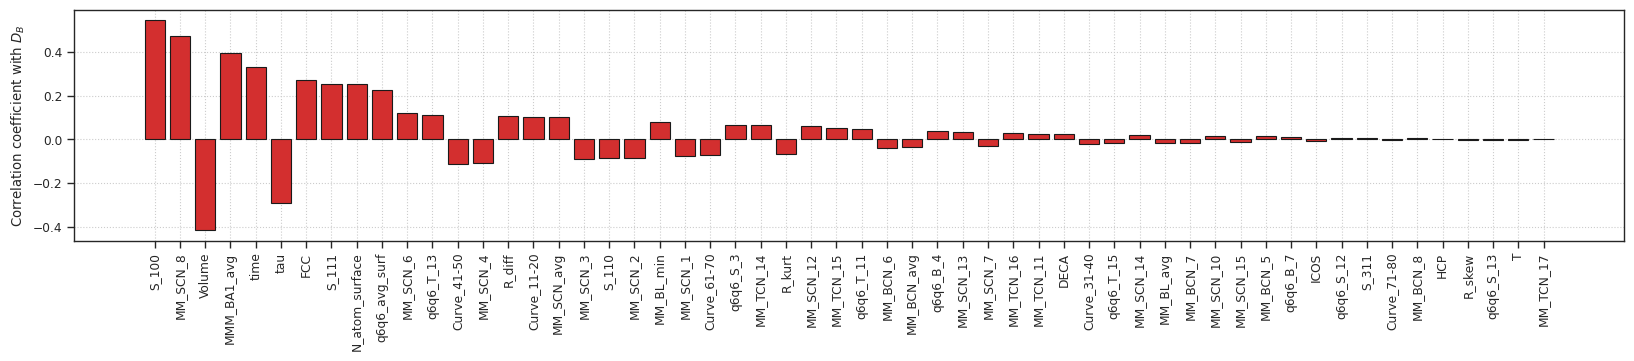

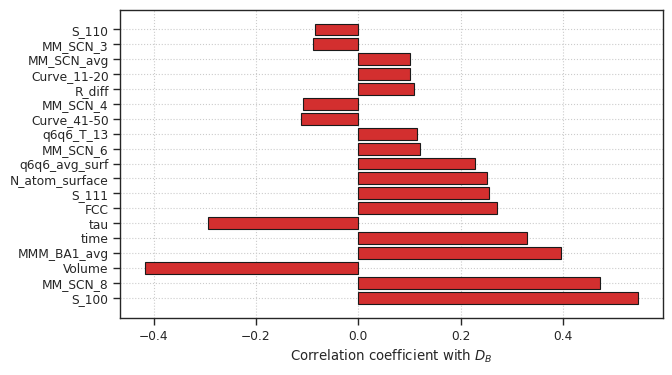

In [29]:
# Top Correlated Features with Box-Counting Dimensions
sns.set_theme(context='paper', style='ticks', palette='colorblind', font='sans-serif', font_scale=1, color_codes=True, rc=None)
MNPHighCorrFeats = MNPDF.corr()['DBoxEX'].sort_values(ascending=False, key=abs)
plotFeatsBCDcorrBar(featsDBoxCorrDF=MNPHighCorrFeats, NPname='MNP', numFeats=None, corrThresh=CORR_THRESH)
plotFeatsBCDcorrBar(featsDBoxCorrDF=MNPHighCorrFeats, NPname='MNP', numFeats=20, corrThresh=CORR_THRESH)

##### Data Storage

In [25]:
# with open(f"{DATA_DIR}/processedMNPdataNoC{int(CORR_THRESH * 100)}.pickle", 'wb') as f:
with open(f"{DATA_DIR}/processedMNPEdataNoC{int(CORR_THRESH * 100)}.pickle", 'wb') as f:
    pickle.dump(MNPDF, f)